# Generative Adversarial Networks

Unless you've been sleeping under a rock, you've probably encountered [Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) before. At least you've seen the pictures. For instance, you can create fake images of bedrooms, as done in [this paper](https://arxiv.org/pdf/1511.06434.pdf) by Radford et al. in 2015. 

![](img/fake_bedrooms.png)

At their heart GANs use the notion that a data generator is good, if we cannot tell fake data apart from real data. In statistics this is called a two-sample test - a test to answer the question whether datasets $X = \{x_1, \ldots x_n\}$ and $X' = \{x_1', \ldots x_n'\}$ were drawn from the same distribution. The main difference to most statistics papers is that GANs use this idea in a constructive way. In other words, rather than just telling a user that 'hey, these two datasets don't look like they came from the same distribution', this allows us to improve the data generator until it is close to the real data. Or at least indistinguishable from it, as far as a classifier is concerned. 

As you can see, there are two pieces to GANs - first off, we need a device (say, a deep network but it really could be anything, such as a game rendering engine) that might potentially be able to generate data that looks just like the real thing. Obviously, if we are dealing with images, this needs to generate images. If we're dealing with speech, it needs to generate audio sequences, and so on. We call this the *generator network*. The second component is the *adversarial network*. It attempts to distinguish fake and real data from each other. Both networks are in competition with each other. The generator network attempts to fool the discriminator. At that point, the discriminator network adapts to the new fake data. This information, in turn is used to improve the generator network, and so on. 

**Generator**
* Draw some parameter $u$ from a source of randomness, e.g. a normal distribution $u \sim \mathcal{N}(0,1)$.
* Apply a function $f$ such that we get $x' = g(u,w)$
* Compute the gradient with respect to $w$ to minimize $\log p(y = \mathrm{fake}|x')$ 

**Discriminator**
* Improve the accuracy of a binary classifier $f$, i.e. maximize $\log p(y=\mathrm{fake}|x')$ and $\log p(y=\mathrm{true}|x)$ for fake and real data respectively.

In short, there are two optimization problems running simultaneously, and the optimization terminates if a stalemate has been reached. There are lots of further tricks and details on how to modify this basic setting. For instance, we could try solving this problem in the presence of side information. This leads to cGAN, i.e. conditional Generative Adversarial Networks. We can change the way how to we detect whether real and fake data look the same. This leads to wGAN (Wasserstein GAN), kernel-inspired GANs and lots of other settings, or we could change how closely we look at the objects. E.g. fake images might look real at the texture level but not so at the larger level, or vice versa. 

Many of the applications are in the context of images. Since this takes too much time to solve in a Jupyter notebook on a laptop, we're going to content ourselves with fitting much simpler distribution. We will illustrate what happens if we use GANs to build the world's most inefficient estimator of parameters for a Gaussian. Let's get started.


In [1]:
from __future__ import print_function
import matplotlib as mpl
from matplotlib import pyplot as plt

import mxnet as mx
from mxnet import gluon
from mxnet import ndarray as nd
from mxnet.gluon import nn
from mxnet import autograd
import numpy as np

ctx = mx.cpu()

## Generate some 'real' data

Since this is going to be the world's lamest example, we simply generate data drawn from a Gaussian. And let's also set a context where we'll do most of the computation.

In [2]:
X = nd.random_normal(shape=(1000, 2))
A = nd.array([[1, 2], [-0.1, 0.5]])
b = nd.array([1, 2])
X = nd.dot(X,A) + b
Y = nd.ones(shape=(1000,1))

# and stick them into an iterator
batch_size = 4
train_data = mx.io.NDArrayIter(X, Y, batch_size, shuffle=True)

Let's see what we got. This should be a Gaussian shifted in some rather arbitrary way with mean $b$ and covariance matrix $A^\top A$.

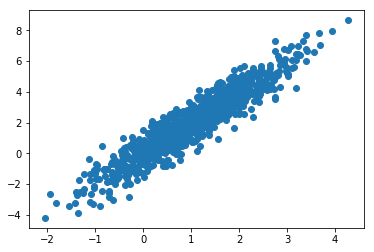

The covariance matrix is

[[ 5.          0.89999998]
 [ 0.89999998  0.25999999]]
<NDArray 2x2 @cpu(0)>


In [3]:
plt.scatter(X[:, 0].asnumpy(),X[:,1].asnumpy())
plt.show()
print("The covariance matrix is")
print(nd.dot(A, A.T))

## Defining the networks

Next we need to define how to fake data. Our generator network will be the simplest network possible - a single layer linear model. This is since we'll be driving that linear network with a Gaussian data generator. Hence, it literally only needs to learn the parameters to fake things perfectly. For the discriminator we will be a bit more discriminating: we will use an MLP with 3 layers to make things a bit more interesting. 

The cool thing here is that we have *two* different networks, each of them with their own gradients, optimizers, losses, etc. that we can optimize as we please. 

In [4]:
# build the generator
netG = nn.Sequential()
netG.add(nn.Dense(2))

# build the discriminator (with 5 and 3 hidden units respectively)
netD = nn.Sequential()
netD.add(nn.Dense(3))
netD.add(nn.Dense(1))

# loss
loss = gluon.loss.SoftmaxCrossEntropyLoss()

# initialize the generator and the discriminator
netG.initialize(mx.init.Normal(0.02), ctx=ctx)
netD.initialize(mx.init.Normal(0.02), ctx=ctx)

# trainer for the generator and the discriminator
trainerG = gluon.Trainer(netG.collect_params(), 'adam', {'learning_rate': 0.01})
trainerD = gluon.Trainer(netD.collect_params(), 'adam', {'learning_rate': 0.01})

## Setting up the training loop

We are going to iterate over the data a few times. To make life simpler we need a few variables

In [5]:
real_label = mx.nd.ones((batch_size,), ctx=ctx)
fake_label = mx.nd.zeros((batch_size,), ctx=ctx)
metric = mx.metric.Accuracy()

# set up logging
from datetime import datetime
import os
import time

## Training loop



In [8]:
stamp =  datetime.now().strftime('%Y_%m_%d-%H_%M')
for epoch in range(10):
    tic = time.time()
    btic = time.time()
    train_data.reset()
    for iter, batch in enumerate(train_data):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real_t
        data = batch.data[0].as_in_context(ctx)
        noise = mx.nd.random_normal(shape=(batch_size, 2), ctx=ctx)

        with autograd.record():
            output = netD(data)
            errD_real = loss(output, real_label)
            metric.update([real_label,], [output,])

            fake = netG(noise)
            output = netD(fake.detach())
            errD_fake = loss(output, fake_label)
            errD = errD_real + errD_fake
            errD.backward()
            metric.update([fake_label,], [output,])

        trainerD.step(batch_size)

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        with autograd.record():
            output = netD(fake)
            errG = loss(output, real_label)
            errG.backward()

        trainerG.step(batch_size)

        name, acc = metric.get()
        # logging.info('speed: {} samples/s'.format(opt.batch_size / (time.time() - btic)))
        print('discriminator loss = %f, generator loss = %f, binary training acc = %f at iter %d epoch %d' %(mx.nd.mean(errD).asscalar(), mx.nd.mean(errG).asscalar(), acc, iter, epoch))
        
        iter = iter + 1
        btic = time.time()

    name, acc = metric.get()
    metric.reset()
    print('\nbinary training acc at epoch %d: %s=%f' % (epoch, name, acc))
    print('time: %f' % (time.time() - tic))



discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 0 epoch 0
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 1 epoch 0
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 2 epoch 0
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 3 epoch 0
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 4 epoch 0
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 5 epoch 0
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 6 epoch 0
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 7 epoch 0
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 8 epoch 0
discriminator loss = 0.000000, genera

discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 77 epoch 0
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 78 epoch 0
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 79 epoch 0
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 80 epoch 0
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 81 epoch 0
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 82 epoch 0
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 83 epoch 0
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 84 epoch 0
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 85 epoch 0
discriminator loss = 0.00000

discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 165 epoch 0
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 166 epoch 0
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 167 epoch 0
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 168 epoch 0
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 169 epoch 0
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 170 epoch 0
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 171 epoch 0
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 172 epoch 0
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 173 epoch 0
discriminator loss 

discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 243 epoch 0
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 244 epoch 0
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 245 epoch 0
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 246 epoch 0
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 247 epoch 0
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 248 epoch 0
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 249 epoch 0

binary training acc at epoch 0: accuracy=0.500000
time: 2.139050
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 0 epoch 1
discriminator loss = 0.000000, generator loss = 0.000000, binary

discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 71 epoch 1
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 72 epoch 1
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 73 epoch 1
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 74 epoch 1
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 75 epoch 1
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 76 epoch 1
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 77 epoch 1
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 78 epoch 1
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 79 epoch 1
discriminator loss = 0.00000

discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 150 epoch 1
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 151 epoch 1
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 152 epoch 1
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 153 epoch 1
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 154 epoch 1
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 155 epoch 1
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 156 epoch 1
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 157 epoch 1
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 158 epoch 1
discriminator loss 

discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 231 epoch 1
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 232 epoch 1
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 233 epoch 1
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 234 epoch 1
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 235 epoch 1
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 236 epoch 1
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 237 epoch 1
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 238 epoch 1
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 239 epoch 1
discriminator loss 

discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 72 epoch 2
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 73 epoch 2
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 74 epoch 2
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 75 epoch 2
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 76 epoch 2
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 77 epoch 2
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 78 epoch 2
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 79 epoch 2
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 80 epoch 2
discriminator loss = 0.00000

discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 156 epoch 2
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 157 epoch 2
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 158 epoch 2
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 159 epoch 2
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 160 epoch 2
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 161 epoch 2
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 162 epoch 2
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 163 epoch 2
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 164 epoch 2
discriminator loss 

discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 237 epoch 2
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 238 epoch 2
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 239 epoch 2
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 240 epoch 2
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 241 epoch 2
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 242 epoch 2
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 243 epoch 2
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 244 epoch 2
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 245 epoch 2
discriminator loss 

discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 67 epoch 3
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 68 epoch 3
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 69 epoch 3
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 70 epoch 3
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 71 epoch 3
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 72 epoch 3
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 73 epoch 3
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 74 epoch 3
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 75 epoch 3
discriminator loss = 0.00000

discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 155 epoch 3
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 156 epoch 3
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 157 epoch 3
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 158 epoch 3
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 159 epoch 3
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 160 epoch 3
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 161 epoch 3
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 162 epoch 3
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 163 epoch 3
discriminator loss 

discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 238 epoch 3
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 239 epoch 3
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 240 epoch 3
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 241 epoch 3
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 242 epoch 3
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 243 epoch 3
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 244 epoch 3
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 245 epoch 3
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 246 epoch 3
discriminator loss 

discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 79 epoch 4
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 80 epoch 4
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 81 epoch 4
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 82 epoch 4
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 83 epoch 4
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 84 epoch 4
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 85 epoch 4
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 86 epoch 4
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 87 epoch 4
discriminator loss = 0.00000

discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 161 epoch 4
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 162 epoch 4
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 163 epoch 4
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 164 epoch 4
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 165 epoch 4
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 166 epoch 4
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 167 epoch 4
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 168 epoch 4
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 169 epoch 4
discriminator loss 

discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 15 epoch 5
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 16 epoch 5
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 17 epoch 5
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 18 epoch 5
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 19 epoch 5
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 20 epoch 5
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 21 epoch 5
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 22 epoch 5
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 23 epoch 5
discriminator loss = 0.00000

discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 99 epoch 5
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 100 epoch 5
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 101 epoch 5
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 102 epoch 5
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 103 epoch 5
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 104 epoch 5
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 105 epoch 5
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 106 epoch 5
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 107 epoch 5
discriminator loss =

discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 189 epoch 5
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 190 epoch 5
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 191 epoch 5
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 192 epoch 5
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 193 epoch 5
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 194 epoch 5
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 195 epoch 5
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 196 epoch 5
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 197 epoch 5
discriminator loss 

discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 22 epoch 6
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 23 epoch 6
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 24 epoch 6
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 25 epoch 6
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 26 epoch 6
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 27 epoch 6
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 28 epoch 6
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 29 epoch 6
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 30 epoch 6
discriminator loss = 0.00000

discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 114 epoch 6
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 115 epoch 6
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 116 epoch 6
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 117 epoch 6
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 118 epoch 6
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 119 epoch 6
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 120 epoch 6
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 121 epoch 6
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 122 epoch 6
discriminator loss 

discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 201 epoch 6
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 202 epoch 6
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 203 epoch 6
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 204 epoch 6
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 205 epoch 6
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 206 epoch 6
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 207 epoch 6
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 208 epoch 6
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 209 epoch 6
discriminator loss 

discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 39 epoch 7
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 40 epoch 7
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 41 epoch 7
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 42 epoch 7
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 43 epoch 7
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 44 epoch 7
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 45 epoch 7
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 46 epoch 7
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 47 epoch 7
discriminator loss = 0.00000

discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 124 epoch 7
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 125 epoch 7
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 126 epoch 7
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 127 epoch 7
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 128 epoch 7
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 129 epoch 7
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 130 epoch 7
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 131 epoch 7
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 132 epoch 7
discriminator loss 

discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 210 epoch 7
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 211 epoch 7
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 212 epoch 7
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 213 epoch 7
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 214 epoch 7
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 215 epoch 7
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 216 epoch 7
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 217 epoch 7
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 218 epoch 7
discriminator loss 

discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 44 epoch 8
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 45 epoch 8
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 46 epoch 8
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 47 epoch 8
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 48 epoch 8
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 49 epoch 8
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 50 epoch 8
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 51 epoch 8
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 52 epoch 8
discriminator loss = 0.00000

discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 128 epoch 8
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 129 epoch 8
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 130 epoch 8
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 131 epoch 8
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 132 epoch 8
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 133 epoch 8
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 134 epoch 8
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 135 epoch 8
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 136 epoch 8
discriminator loss 

discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 215 epoch 8
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 216 epoch 8
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 217 epoch 8
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 218 epoch 8
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 219 epoch 8
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 220 epoch 8
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 221 epoch 8
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 222 epoch 8
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 223 epoch 8
discriminator loss 

discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 49 epoch 9
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 50 epoch 9
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 51 epoch 9
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 52 epoch 9
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 53 epoch 9
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 54 epoch 9
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 55 epoch 9
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 56 epoch 9
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 57 epoch 9
discriminator loss = 0.00000

discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 132 epoch 9
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 133 epoch 9
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 134 epoch 9
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 135 epoch 9
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 136 epoch 9
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 137 epoch 9
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 138 epoch 9
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 139 epoch 9
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 140 epoch 9
discriminator loss 

discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 221 epoch 9
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 222 epoch 9
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 223 epoch 9
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 224 epoch 9
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 225 epoch 9
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 226 epoch 9
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 227 epoch 9
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 228 epoch 9
discriminator loss = 0.000000, generator loss = 0.000000, binary training acc = 0.500000 at iter 229 epoch 9
discriminator loss 

## Define loss

Instead of writing our own loss function wer'e just going to call down to ``gluon.loss.L2Loss`` 

## Conclusion 

As you can see, even for a simple eample like linear regression, ``gluon`` can help you to write quick, clean, clode. Next, we'll repeat this exercise for multilayer perceptrons, extending these lessons to deep neural networks and (comparatively) real datasets. 

For whinges or inquiries, [open an issue on  GitHub.](https://github.com/zackchase/mxnet-the-straight-dope)